<a href="https://colab.research.google.com/github/Kovibordy/ML-2.0/blob/main/Lab_4.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas seaborn scikit-learn

# Домашнее задание 4

1. Преобразовать датасет (процессинг категориальных признаков, копия данных в df_not_processed, scale датасета)
2. Сделать k-means кластеризацию (записать cluster в df_not_processed, вывести статистику, графики. попробовать объяснить принцип кластеризации), оценить метриками, вывести результат
3. Подобрать оптимальное число кластеров с помощью "метод локтя", вывести статистику, графики, метрики, объяснить результат
4. Сделать DBSSCAN кластеризацию, подобрать оптимальные параметры, посчитать метрики, вывести статистику, объяснить результат
5. Ответить на вопрос - какой из методов кластеризации больше подходит для вашего датасета

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/Sleep_health_and_lifestyle_dataset.csv')

In [ ]:
# Объединить дубликаты
df['BMI Category'] = df['BMI Category'].replace('Normal Weight', 'Normal')

## 1. Преобразовать датасет (процессинг категориальных признаков, копия данных в df_not_processed, scale датасета)

In [ ]:
# Сохраняем оригинальный датасет (до масштабирования) для анализа
df_not_processed = df.copy()

# Обработка категориальных признаков (Gender, Occupation, BMI Category, Blood Pressure, Sleep Disorder)
category_columns = df.select_dtypes(include=['object']).columns.tolist()
print(f"\nКатегориальные колонки для обработки: {category_columns}")


Категориальные колонки для обработки: ['Gender', 'Occupation', 'BMI Category', 'Blood Pressure', 'Sleep Disorder']


In [ ]:
# Применяем One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=category_columns, drop_first=True)

print(f"\nРазмерность датасета после кодирования: {df_encoded.shape}")
print(f"Колонки после кодирования: {list(df_encoded.columns)}")


Размерность датасета после кодирования: (374, 47)
Колонки после кодирования: ['Person ID', 'Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps', 'Gender_Male', 'Occupation_Doctor', 'Occupation_Engineer', 'Occupation_Lawyer', 'Occupation_Manager', 'Occupation_Nurse', 'Occupation_Sales Representative', 'Occupation_Salesperson', 'Occupation_Scientist', 'Occupation_Software Engineer', 'Occupation_Teacher', 'BMI Category_Normal Weight', 'BMI Category_Obese', 'BMI Category_Overweight', 'Blood Pressure_115/78', 'Blood Pressure_117/76', 'Blood Pressure_118/75', 'Blood Pressure_118/76', 'Blood Pressure_119/77', 'Blood Pressure_120/80', 'Blood Pressure_121/79', 'Blood Pressure_122/80', 'Blood Pressure_125/80', 'Blood Pressure_125/82', 'Blood Pressure_126/83', 'Blood Pressure_128/84', 'Blood Pressure_128/85', 'Blood Pressure_129/84', 'Blood Pressure_130/85', 'Blood Pressure_130/86', 'Blood Pressure_131/86', 'Blood Pressure_132/87', '

In [ ]:
# Выбираем числовые признаки для масштабирования
numeric_features = df_encoded.select_dtypes(include=['float64', 'int64']).columns.tolist()
# Удаляем 'Person ID', если он остался, так как это идентификатор, не признак
if 'Person ID' in numeric_features:
    numeric_features.remove('Person ID')

print(f"\nЧисловые признаки для масштабирования: {numeric_features}")


Числовые признаки для масштабирования: ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps']


In [ ]:
# Масштабируем данные (используем StandardScaler как альтернатива MinMaxScaler)
scaler = StandardScaler()
df_scaled = df_encoded.copy()
df_scaled[numeric_features] = scaler.fit_transform(df_scaled[numeric_features])

print("\nДатасет после масштабирования (первые 5 строк):")
print(df_scaled.head())


Датасет после масштабирования (первые 5 строк):
   Person ID       Age  Sleep Duration  Quality of Sleep  \
0          1 -1.753096       -1.298887         -1.098280   
1          2 -1.637643       -1.173036         -1.098280   
2          3 -1.637643       -1.173036         -1.098280   
3          4 -1.637643       -1.550588         -2.771424   
4          5 -1.637643       -1.550588         -2.771424   

   Physical Activity Level  Stress Level  Heart Rate  Daily Steps  \
0                -0.825418      0.347021    1.654719    -1.619584   
1                 0.039844      1.475592    1.170474     1.970077   
2                 0.039844      1.475592    1.170474     1.970077   
3                -1.402260      1.475592    3.591698    -2.362273   
4                -1.402260      1.475592    3.591698    -2.362273   

   Gender_Male  Occupation_Doctor  ...  Blood Pressure_130/86  \
0         True              False  ...                  False   
1         True               True  ...       

Каждый признак имеет среднее значение 0 и стандартное отклонение 1. Это позволяет сравнивать влияние разных признаков на алгоритмы кластеризации на "равных условиях", так как все они теперь выражены в единицах стандартного отклонения от своего среднего.

## 2. Сделать k-means кластеризацию (записать cluster в df_not_processed, вывести статистику, графики. попробовать объяснить принцип кластеризации), оценить метриками, вывести результат

In [ ]:
# Выбираем признаки для кластеризации (без 'Person ID')
X_for_clustering = df_scaled.drop(columns=['Person ID'])

In [ ]:
# Определяем количество кластеров (k=3 как пример, см. пункт 3 для оптимизации)
k_initial = 3
kmeans = KMeans(n_clusters=k_initial, random_state=42, n_init=10)
cluster_labels_kmeans = kmeans.fit_predict(X_for_clustering)

In [ ]:
# Добавляем метки кластеров в датасет для анализа
df_not_processed['Cluster_KMeans'] = cluster_labels_kmeans

print(f"Метки кластеров K-Means добавлены в df_not_processed.")
print(f"Распределение по кластерам:\n{df_not_processed['Cluster_KMeans'].value_counts().sort_index()}")

Метки кластеров K-Means добавлены в df_not_processed.
Распределение по кластерам:
Cluster_KMeans
0    240
1     32
2    102
Name: count, dtype: int64


K-Means разделил данные на три группы

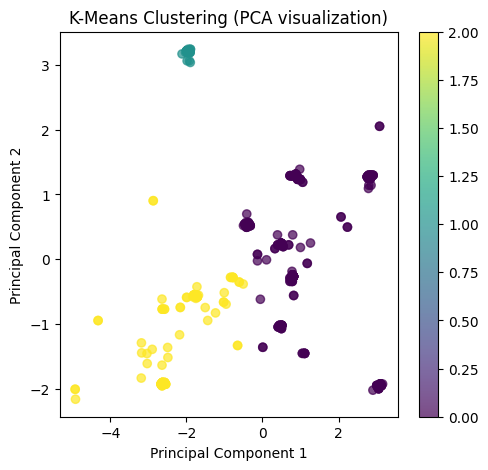

In [ ]:
# Визуализация (используем PCA для 2D)
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_for_clustering)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=cluster_labels_kmeans, cmap='viridis', alpha=0.7)
plt.title('K-Means Clustering (PCA visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter)

График визуально подтверждает результат работы алгоритма K-Means, показывая, что данные были разбиты на три достаточно хорошо отделимые друг от друга группы.

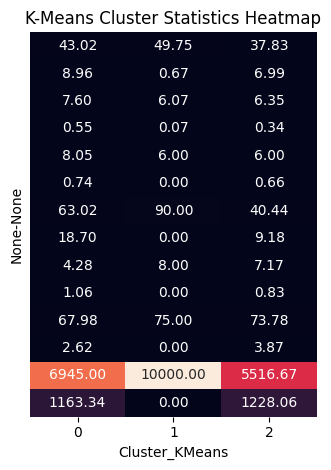

In [ ]:
# Вывод статистики по кластерам
df_analysis_kmeans = df_not_processed.groupby('Cluster_KMeans').agg({
    'Age': ['mean', 'std'],
    'Sleep Duration': ['mean', 'std'],
    'Quality of Sleep': ['mean', 'std'],
    'Physical Activity Level': ['mean', 'std'],
    'Stress Level': ['mean', 'std'],
    'Heart Rate': ['mean', 'std'],
    'Daily Steps': ['mean', 'std']
}).round(2)

plt.subplot(1, 2, 2)
sns.heatmap(df_analysis_kmeans.T, annot=True, fmt=".2f", cbar=False, yticklabels=False)
plt.title('K-Means Cluster Statistics Heatmap')

plt.tight_layout()
plt.show()

In [ ]:
# Оценка метриками
silhouette_avg_kmeans = silhouette_score(X_for_clustering, cluster_labels_kmeans)
calinski_harabasz_score_kmeans = calinski_harabasz_score(X_for_clustering, cluster_labels_kmeans)
davies_bouldin_score_kmeans = davies_bouldin_score(X_for_clustering, cluster_labels_kmeans)

print(f"\nМетрики для K-Means (k={k_initial}):")
print(f"Silhouette Score: {silhouette_avg_kmeans:.4f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_score_kmeans:.4f}")
print(f"Davies-Bouldin Score: {davies_bouldin_score_kmeans:.4f}")


Метрики для K-Means (k=3):
Silhouette Score: 0.3779
Calinski-Harabasz Score: 138.8995
Davies-Bouldin Score: 1.0152


Видим что значения второй метрики довольно высокие, что говорит нам о хорошем качестве модели, но первое и третье указывают нам о среднем качестве

## 3. Подобрать оптимальное число кластеров с помощью "метод локтя", вывести статистику, графики, метрики, объяснить результат

In [ ]:
K_range = range(2, 11)
inertias = []
silhouettes = []
ch_scores = []
db_scores = []

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_for_clustering)

    inertias.append(kmeans_temp.inertia_)
    silhouettes.append(silhouette_score(X_for_clustering, kmeans_temp.labels_))
    ch_scores.append(calinski_harabasz_score(X_for_clustering, kmeans_temp.labels_))
    db_scores.append(davies_bouldin_score(X_for_clustering, kmeans_temp.labels_))

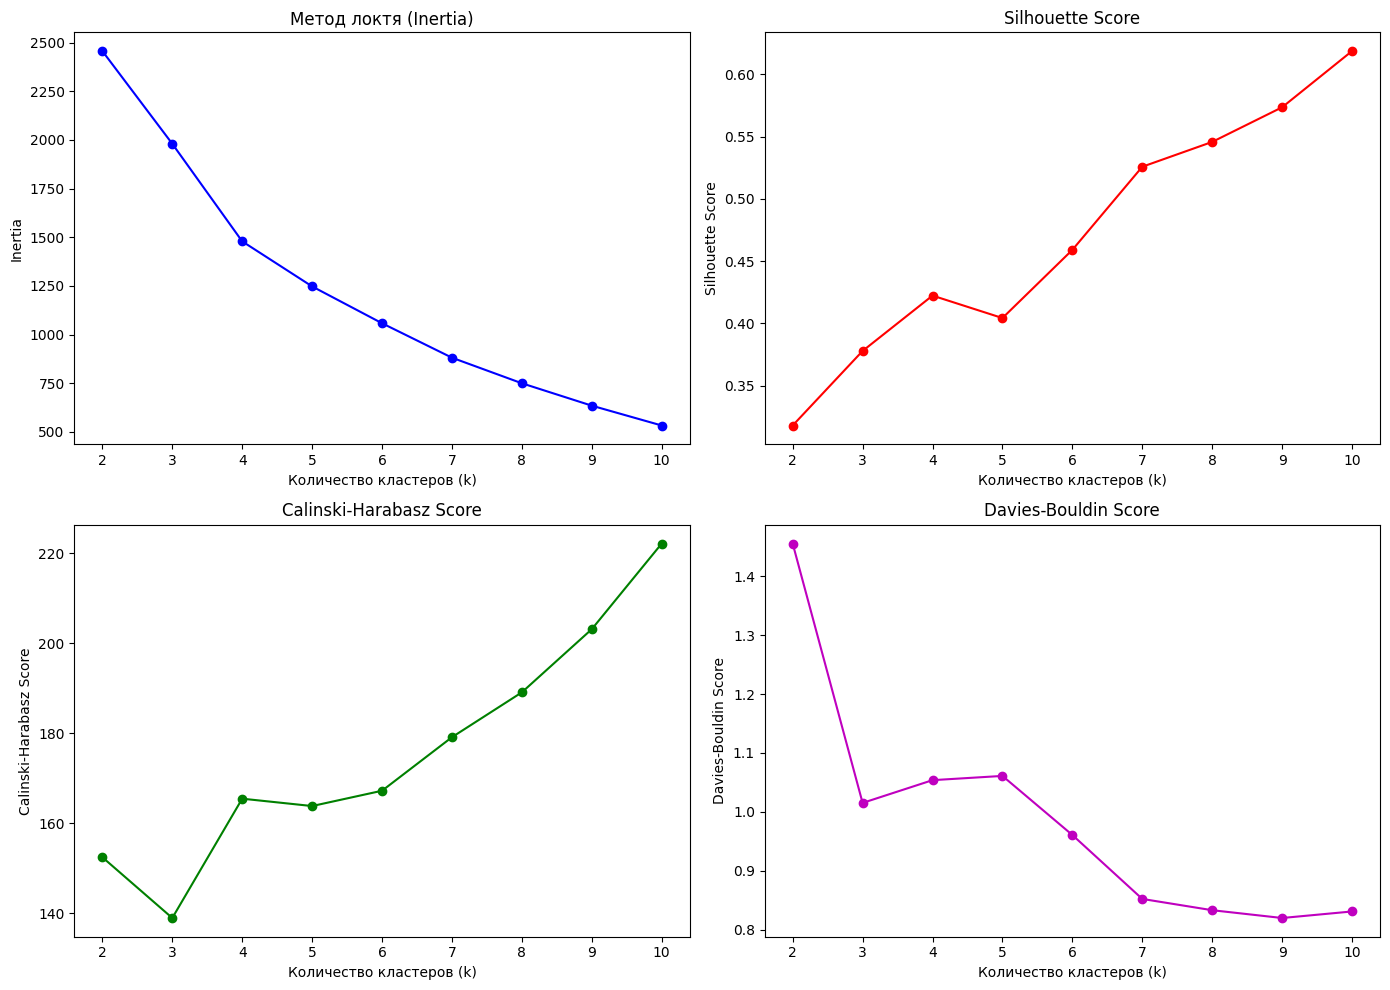

In [ ]:
# Визуализация
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
ax = ax.ravel()

ax[0].plot(K_range, inertias, 'bo-')
ax[0].set_title('Метод локтя (Inertia)')
ax[0].set_xlabel('Количество кластеров (k)')
ax[0].set_ylabel('Inertia')

ax[1].plot(K_range, silhouettes, 'ro-')
ax[1].set_title('Silhouette Score')
ax[1].set_xlabel('Количество кластеров (k)')
ax[1].set_ylabel('Silhouette Score')

ax[2].plot(K_range, ch_scores, 'go-')
ax[2].set_title('Calinski-Harabasz Score')
ax[2].set_xlabel('Количество кластеров (k)')
ax[2].set_ylabel('Calinski-Harabasz Score')

ax[3].plot(K_range, db_scores, 'mo-')
ax[3].set_title('Davies-Bouldin Score')
ax[3].set_xlabel('Количество кластеров (k)')
ax[3].set_ylabel('Davies-Bouldin Score')

plt.tight_layout()
plt.show()

In [ ]:
# Вывод метрик в таблице
metrics_comparison = pd.DataFrame({
    'k': K_range,
    'Inertia': inertias,
    'Silhouette_Score': silhouettes,
    'Calinski_Harabasz_Score': ch_scores,
    'Davies_Bouldin_Score': db_scores
})

print("\nСравнение метрик для разных k:")
print(metrics_comparison.round(4))


Сравнение метрик для разных k:
    k    Inertia  Silhouette_Score  Calinski_Harabasz_Score  \
0   2  2456.8074            0.3181                 152.4164   
1   3  1980.4696            0.3779                 138.8995   
2   4  1479.1876            0.4223                 165.4431   
3   5  1247.7751            0.4043                 163.8057   
4   6  1058.5386            0.4590                 167.2106   
5   7   881.6245            0.5257                 179.1233   
6   8   750.1807            0.5457                 189.1056   
7   9   635.1706            0.5735                 203.1558   
8  10   533.3294            0.6186                 222.1997   

   Davies_Bouldin_Score  
0                1.4557  
1                1.0152  
2                1.0539  
3                1.0611  
4                0.9608  
5                0.8522  
6                0.8330  
7                0.8198  
8                0.8309  


С помощью метода локтя можем сделать вывод, что оптимальным вариантом будет увеличить число кластеров до 10, чтоб +/- удовлетворять метрикам качества кластеризации

In [ ]:
# Выбор оптимального k (например, по Silhouette Score)
optimal_k_sil = K_range[np.argmax(silhouettes)]
print(f"\nОптимальное k по Silhouette Score: {optimal_k_sil}")
print(f"Silhouette Score для k={optimal_k_sil}: {max(silhouettes):.4f}")


Оптимальное k по Silhouette Score: 10
Silhouette Score для k=10: 0.6186


Уже явно ближе к еденице, поэтому видим улучшения

In [ ]:
# Обучаем K-Means с оптимальным k
kmeans_opt = KMeans(n_clusters=optimal_k_sil, random_state=42, n_init=10)
cluster_labels_kmeans_opt = kmeans_opt.fit_predict(X_for_clustering)
df_not_processed['Cluster_KMeans_Opt'] = cluster_labels_kmeans_opt

print(f"\nK-Means с оптимальным k ({optimal_k_sil}) выполнен.")
print(f"Распределение по оптимальным кластерам:\n{df_not_processed['Cluster_KMeans_Opt'].value_counts().sort_index()}")


K-Means с оптимальным k (10) выполнен.
Распределение по оптимальным кластерам:
Cluster_KMeans_Opt
0    31
1    37
2    53
3    51
4    32
5    34
6    32
7    58
8    17
9    29
Name: count, dtype: int64


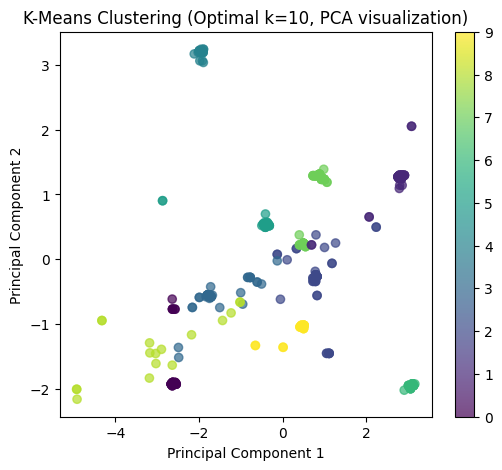

In [ ]:
# Визуализация оптимального K-Means
plt.figure(figsize=(6, 5))
scatter_opt = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=cluster_labels_kmeans_opt, cmap='viridis', alpha=0.7)
plt.title(f'K-Means Clustering (Optimal k={optimal_k_sil}, PCA visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter_opt)
plt.show()

In [ ]:
# Оценка метриками для оптимального k
silhouette_opt = silhouette_score(X_for_clustering, cluster_labels_kmeans_opt)
ch_score_opt = calinski_harabasz_score(X_for_clustering, cluster_labels_kmeans_opt)
db_score_opt = davies_bouldin_score(X_for_clustering, cluster_labels_kmeans_opt)

print(f"\nМетрики для оптимального K-Means (k={optimal_k_sil}):")
print(f"Silhouette Score: {silhouette_opt:.4f}")
print(f"Calinski-Harabasz Score: {ch_score_opt:.4f}")
print(f"Davies-Bouldin Score: {db_score_opt:.4f}")


Метрики для оптимального K-Means (k=10):
Silhouette Score: 0.6186
Calinski-Harabasz Score: 222.1997
Davies-Bouldin Score: 0.8309


Видим хорошие изменения по всем трём метрикам

# 4. DBSCAN кластеризация

In [ ]:
# Подбор параметров eps и min_samples
# DBSCAN чувствителен к масштабу, поэтому используем StandardScaler
# X_scaled уже нормализован, но можно повторить для уверенности
scaler_dbscan = StandardScaler()
X_scaled_dbscan = scaler_dbscan.fit_transform(X_for_clustering)

best_eps = None
best_min_samples = None
best_n_clusters = -1
best_silhouette = -1
results_dbscan = []

for eps in [0.3, 0.4, 0.5, 0.6, 0.7]:
    for min_samples in [3, 4, 5, 6, 7]:
        dbscan_temp = DBSCAN(eps=eps, min_samples=min_samples)
        labels_temp = dbscan_temp.fit_predict(X_scaled_dbscan)

        n_clusters_temp = len(set(labels_temp)) - (1 if -1 in labels_temp else 0)
        n_noise_temp = list(labels_temp).count(-1)

        # Считаем метрики только если есть > 1 кластера и < количества точек
        unique_labels_temp = set(labels_temp)
        if n_clusters_temp > 1 and n_clusters_temp < len(X_scaled_dbscan):
            sil_temp = silhouette_score(X_scaled_dbscan, labels_temp)
        else:
            sil_temp = -2 # Невалидное значение

        results_dbscan.append({'eps': eps, 'min_samples': min_samples, 'n_clusters': n_clusters_temp, 'n_noise': n_noise_temp, 'silhouette': sil_temp})

        # Обновляем лучшие параметры по Silhouette Score
        if sil_temp > best_silhouette:
            best_silhouette = sil_temp
            best_eps = eps
            best_min_samples = min_samples
            best_n_clusters = n_clusters_temp

results_df = pd.DataFrame(results_dbscan)
print("\nРезультаты подбора параметров DBSCAN:")
print(results_df.sort_values(by='silhouette', ascending=False).head(10))

print(f"\nЛучшие параметры DBSCAN: eps={best_eps}, min_samples={best_min_samples}")
print(f"Количество кластеров: {best_n_clusters}, Количество шумовых точек: {list(dbscan_temp.labels_).count(-1) if best_eps else 'N/A'}, Silhouette Score: {best_silhouette:.4f}")



Результаты подбора параметров DBSCAN:
    eps  min_samples  n_clusters  n_noise  silhouette
15  0.6            3          17       63    0.723575
20  0.7            3          17       63    0.723575
10  0.5            3          17       65    0.716839
5   0.4            3          17       65    0.716839
0   0.3            3          17       65    0.716839
16  0.6            4          15       69    0.703175
17  0.6            5          15       69    0.703175
22  0.7            5          15       69    0.703175
21  0.7            4          15       69    0.703175
12  0.5            5          15       71    0.696405

Лучшие параметры DBSCAN: eps=0.6, min_samples=3
Количество кластеров: 17, Количество шумовых точек: 91, Silhouette Score: 0.7236



DBSCAN с параметрами eps=0.6, min_samples=3 выполнен.
Распределение по кластерам (включая шум -1):
Cluster_DBSCAN
-1     63
 0     31
 1      5
 2     25
 3     26
 4      6
 5      5
 6     24
 7     17
 8     31
 9     25
 10    15
 11    29
 12     3
 13    32
 14     6
 15     3
 16    28
Name: count, dtype: int64


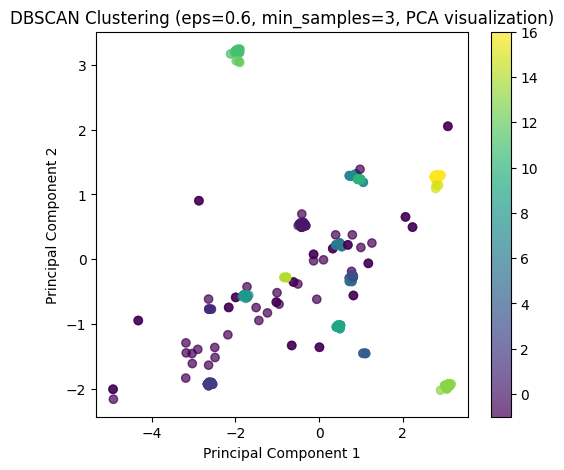


Метрики для DBSCAN (без шума):
Silhouette Score: 0.9473
Calinski-Harabasz Score: 22497.7725
Davies-Bouldin Score: 0.0756


In [ ]:
# Обучаем DBSCAN с лучшими параметрами
if best_eps is not None:
    dbscan_final = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    cluster_labels_dbscan = dbscan_final.fit_predict(X_scaled_dbscan)

    # Добавляем метки кластеров в датасет для анализа
    df_not_processed['Cluster_DBSCAN'] = cluster_labels_dbscan

    print(f"\nDBSCAN с параметрами eps={best_eps}, min_samples={best_min_samples} выполнен.")
    print(f"Распределение по кластерам (включая шум -1):\n{df_not_processed['Cluster_DBSCAN'].value_counts().sort_index()}")

    # Визуализация DBSCAN
    plt.figure(figsize=(6, 5))
    scatter_dbs = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=cluster_labels_dbscan, cmap='viridis', alpha=0.7)
    plt.title(f'DBSCAN Clustering (eps={best_eps}, min_samples={best_min_samples}, PCA visualization)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(scatter_dbs)
    plt.show()

    # Оценка метриками (исключая шумовые точки -1)
    mask_valid_dbscan = cluster_labels_dbscan != -1
    X_valid_dbscan = X_scaled_dbscan[mask_valid_dbscan]
    labels_valid_dbscan = cluster_labels_dbscan[mask_valid_dbscan]

    if len(set(labels_valid_dbscan)) > 1:
        silhouette_dbscan = silhouette_score(X_valid_dbscan, labels_valid_dbscan)
        ch_score_dbscan = calinski_harabasz_score(X_valid_dbscan, labels_valid_dbscan)
        db_score_dbscan = davies_bouldin_score(X_valid_dbscan, labels_valid_dbscan)

        print(f"\nМетрики для DBSCAN (без шума):")
        print(f"Silhouette Score: {silhouette_dbscan:.4f}")
        print(f"Calinski-Harabasz Score: {ch_score_dbscan:.4f}")
        print(f"Davies-Bouldin Score: {db_score_dbscan:.4f}")
    else:
        print("\nПосле удаления шума остался один кластер или не осталось кластеров. Метрики не рассчитываются.")
else:
    print("\nНе удалось найти подходящие параметры для DBSCAN.")

SS: 0.9473 — значение очень близко к 1, что означает, что точки
внутри кластеров чрезвычайно похожи друг на друга и хорошо отделены от других кластеров.

CS: 22497.7725 — огромное значение, указывающее на то, что кластеры очень плотные и при этом сильно разделены друг от друга.

DS: 0.0756 — очень низкое значение (близкое к 0), что также говорит о превосходном качестве: кластеры компактны и находятся далеко друг от друга.

# 5. Сравнение методов

In [ ]:
comparison_results = {
    'Method': ['K-Means (Initial k=3)', f'K-Means (Optimal k={optimal_k_sil})', 'DBSCAN'],
    'Silhouette Score': [
        silhouette_avg_kmeans,
        silhouette_opt,
        silhouette_dbscan if 'silhouette_dbscan' in locals() else 'N/A'
    ],
    'Calinski-Harabasz Score': [
        calinski_harabasz_score_kmeans,
        ch_score_opt,
        ch_score_dbscan if 'ch_score_dbscan' in locals() else 'N/A'
    ],
    'Davies-Bouldin Score': [
        davies_bouldin_score_kmeans,
        db_score_opt,
        db_score_dbscan if 'db_score_dbscan' in locals() else 'N/A'
    ],
    'Number of Clusters': [
        k_initial,
        optimal_k_sil,
        best_n_clusters if best_n_clusters is not None else 'N/A'
    ]
}

comparison_df = pd.DataFrame(comparison_results)
print("\nСравнение метрик:")
print(comparison_df.round(4) if comparison_df.iloc[0,1] != 'N/A' else comparison_df)


Сравнение метрик:
                   Method  Silhouette Score  Calinski-Harabasz Score  \
0   K-Means (Initial k=3)            0.3779                 138.8995   
1  K-Means (Optimal k=10)            0.6186                 222.1997   
2                  DBSCAN            0.9473               22497.7725   

   Davies-Bouldin Score  Number of Clusters  
0                1.0152                   3  
1                0.8309                  10  
2                0.0756                  17  


dbscan показал более хорошие результаты